In [1]:
# Reseteamos todas las variables del entorno
%reset
# IMPORT LIBRARIES

# Processing
import librosa
import librosa.display
import numpy as np
import random
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import IPython.display as ipd

# Files
import os
import joblib
import pickle

# Machine Learning
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix
import keras
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Reshape
import tensorflow as tf

# ####### TEST ####### 
# Scipy
from scipy import signal
from scipy.io import wavfile

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## **CONFIGURACION DEL ENTORNO**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import sys  
GPATH = '/content/drive/My Drive/Master/Asignaturas/2 Cuatrimestre/Proyecto/Code/'

if GPATH + '/SpeechEmotionRecognition' in sys.path:
  sys.path.remove(GPATH + '/SpeechEmotionRecognition')

sys.path.insert(0, GPATH + '/SpeechEmotionRecognition')

sys.path

['/content/drive/My Drive/Master/Asignaturas/2 Cuatrimestre/Proyecto/Code//SpeechEmotionRecognition',
 '',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython']

In [16]:
FEATURES_PATH = GPATH + 'SpeechEmotionRecognition/data/processed/features/'
FIGURES_PATH = GPATH + 'SpeechEmotionRecognition/reports/figures/'
# Datasets
SAVEE_PATH = GPATH + 'data/SAVEE/'
TESS_PATH = GPATH + 'data/TESS/'

CAFFE_PATH = GPATH + 'data/CAFFE/'

# Espectogramas
SPECT_IMG = GPATH + 'data/spectrograms/'
SPECTOGRAM_MODEL = SPECT_IMG + 'mfcc_savee_tess/'

# Maps

EMOTION_MAP = {0: 'happy', 1:'disgust', 2:'angry', 3:'neutral', 4:'surprise', 5:'fear', 6:'sad'}
reduced_values = ['angry', 'disgust', 'happy', 'sad', 'neutral']

## **1. DATOS**

In [17]:
# Leemos CAFFE 
EMOTION_CAFFE_MAP = {'Joie':'happy', 'Tristesse':'sad', 'Colere':'angry','Degout':'disgust', 'Neutre':'neutral', 'Surprise':'surprise', 'Peur':'fear'}
emotion=[]
path = []

for folder in os.listdir(CAFFE_PATH):
  path_dir = os.listdir(CAFFE_PATH + folder)
  for filename in path_dir:
    str_path = CAFFE_PATH + str(folder) + '/' + str(filename)
    emotion.append(EMOTION_CAFFE_MAP[folder])
    path.append(str_path)
  
CAFFE_df = pd.DataFrame(columns=['emotion', 'path'])
CAFFE_df['emotion'] = emotion
CAFFE_df['path'] = path

class_distribution = CAFFE_df['emotion'].value_counts()
print( class_distribution )

neutral     36
surprise    36
disgust     36
angry       36
happy       36
sad         36
fear        36
Name: emotion, dtype: int64


In [8]:
print( class_distribution )

angry      127
neutral     79
happy       71
sad         62
disgust     46
Name: emotion, dtype: int64


In [9]:
# from src.SpeechDataProcess import SpeechDataProcess
# data = SpeechDataProcess('TESS', TESS_PATH)
# TESS_df = data.read()
# data = SpeechDataProcess('SAVEE', SAVEE_PATH)
# SAVEE_df = data.read()

In [10]:
emotion=[]
path = []
reduced_values = ['a', 'd', 'h', 'sa', 'n']

for dir in os.listdir(SAVEE_PATH):
  path_dir = os.listdir(SAVEE_PATH + dir) # todos los archivos de audios asociados a un directorio
  for filename in path_dir:
    str_path = SAVEE_PATH + dir + '/' + str(filename)
    label = filename[0]
    if filename[1].isalpha() : label = filename[0] + filename[1] 
    # Solo los valores reducidos
    if label in reduced_values:
      path.append(str_path)
      if(label=='a'):
          emotion.append("angry")
      elif(label=='h'):
          emotion.append("happy")
      elif(label=='f'):
          emotion.append("fear")
      elif(label=='d'):
          emotion.append("disgust")
      elif(label=='n'):
          emotion.append('neutral')
      elif(label=='sa'):
          emotion.append("sad")
      elif(label=='su'):
          emotion.append("surprise")


SAVEE_df = pd.DataFrame(columns=['emotion', 'path'])
SAVEE_df['emotion'] = emotion
SAVEE_df['path'] = path

SAVEE_df['emotion'].unique()
print( SAVEE_df['emotion'].value_counts() )

neutral    120
sad         60
disgust     60
angry       60
happy       60
Name: emotion, dtype: int64


In [11]:
# Leemos TESS

emotion=[]
path = []
reduced_values = ['angry', 'disgust', 'happy', 'sad', 'neutral']
for dir in os.listdir(TESS_PATH):
  path_dir = os.listdir(TESS_PATH + dir) # todos los archivos de audios asociados a un directorio
  label = dir.split('_')[1]
  for filename in path_dir:
    str_path = TESS_PATH + dir + '/' + str(filename)

    # Solo los valores reducidos
    if label.lower() in reduced_values:
      path.append(str_path)
      emotion.append(label.lower())


TESS_df = pd.DataFrame(columns=['emotion', 'path'])
TESS_df['emotion'] = emotion
TESS_df['path'] = path

print( "Size of the dataset: {} \n".format(len(TESS_df)) )
print( TESS_df['emotion'].value_counts() )
# TESS_df.sample(5)

Size of the dataset: 2000 

neutral    400
happy      400
disgust    400
sad        400
angry      400
Name: emotion, dtype: int64


In [12]:
if len(TESS_df.emotion.unique()) == len(SAVEE_df.emotion.unique()) and len(TESS_df.emotion.unique()) == len(EMODDB_df.emotion.unique()):
  print("Todas las dimensiones son correctas")

Todas las dimensiones son correctas


### **1.2 EXTRACCION DE ESPECTROGRAMAS**

In [19]:
from src.MFCC import MFCC

In [20]:
features_spectMFCC_SAVEE = MFCC(df_data = SAVEE_df, dataset_name = "SAVEE")
features_spectMFCC_TESS = MFCC(df_data = TESS_df, dataset_name = "TESS")

features_spectMFCC_CAFFE = MFCC(df_data = CAFFE_df, dataset_name = "CAFFE")
# list_images, labels = featuresMFCC_SAVEE.load_images(IMG_MFCC, (40,40))

In [21]:
# # Genero los espectrogramas
# features_spectMFCC_SAVEE.generate_spectrograms(SPECT_IMG)
# features_spectMFCC_TESS.generate_spectrograms(SPECT_IMG)

# # Genero los espectogramas de test
# features_spectMFCC_CAFFE.generate_spectrograms(SPECT_IMG + 'test_caffe/')


In [22]:
list_images_savee_tess, labels = features_spectMFCC_TESS.load_spectograms_dataset(SPECTOGRAM_MODEL, (30,40))

Leídas 460 espectogramas pertenecientes a angry
Leídas 460 espectogramas pertenecientes a disgust
Leídas 460 espectogramas pertenecientes a fear
Leídas 460 espectogramas pertenecientes a happy
Leídas 524 espectogramas pertenecientes a neutral
Leídas 460 espectogramas pertenecientes a sad
Leídas 460 espectogramas pertenecientes a surprise


In [23]:
array_images_savee_tess = np.array(list_images_savee_tess)
print("{} imagenes con dimension {}".format(array_images_savee_tess.shape[0], array_images_savee_tess.shape[1:]))

3284 imagenes con dimension (40, 30, 3)


In [24]:
list_images_caffe, labels_caffe = features_spectMFCC_CAFFE.load_spectograms_dataset(SPECT_IMG + 'test_caffe/', (30,40))
array_images_caffe= np.array(list_images_caffe)

Leídas 36 espectogramas pertenecientes a happy
Leídas 36 espectogramas pertenecientes a disgust
Leídas 36 espectogramas pertenecientes a angry
Leídas 36 espectogramas pertenecientes a neutral
Leídas 36 espectogramas pertenecientes a surprise
Leídas 36 espectogramas pertenecientes a fear
Leídas 36 espectogramas pertenecientes a sad


## **2. DEFINICION DEL MODELO**

In [25]:
def get_model_LSTM_CNN(shape, classes):
  model = Sequential()

  # 1 Capa CNN 2D
  model.add(Conv2D(64, (3, 3), padding = 'same', input_shape = shape, activation = 'relu')) # (128, 128, 3)
  model.add(MaxPooling2D(pool_size = (2, 2)))

  # 2 Capa CNN 2D
  model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2, 2)))

  # 3 Capa CNN 2D
  model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2, 2)))

  # Capa Flatten
  model.add(Flatten())
  model.add(Dropout(rate = 0.5))

  # Capas LSTM 1D
  model.add(Reshape((1, 960))) 
  model.add(LSTM(units = 50, return_sequences = True, dropout = 0.5))
  model.add(LSTM(units = 20, return_sequences = False, dropout = 0.5))

  model.add(Dense(classes, activation = 'softmax'))

  return model


def plot_loss_acc(history):
  # Mostramos la grafica loss 
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
  ax1.plot(history.history['loss'])
  ax1.plot(history.history['val_loss'])
  ax1.set_title('Loss')
  ax1.set(xlabel='epoch', ylabel='loss')
  ax1.legend(['train', 'test'], loc='upper right')

  # Mostramos la grafica accuracy
  ax2.plot(history.history['accuracy'])
  ax2.plot(history.history['val_accuracy'])
  ax2.set_title('Validation')
  ax2.set(xlabel='epoch', ylabel='acc')

  ax2.legend(['train', 'test'], loc='lower right')


def processData(data, labels, test_size = 0.25):
  X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=test_size, shuffle=True, random_state=42)

  # one hot encoding 
  lb = LabelEncoder()
  y_train = np_utils.to_categorical(lb.fit_transform(y_train))
  y_test = np_utils.to_categorical(lb.fit_transform(y_test))

  # Normalization as per the standard NN process
  mean = np.mean(X_train, axis=0)
  std = np.std(X_train, axis=0)

  X_train = (X_train - mean)/std
  X_test = (X_test - mean)/std

  return X_train, X_test, y_train, y_test

  

#### **2.1 ENTRENAMIENTO**

In [26]:
X_train, X_test, y_train, y_test = processData(array_images_savee_tess, labels, 0.3)

In [27]:
print("Entrenamiento: Datos con dimension {}, y clases con {}".format(X_train.shape, y_train.shape))
print("Test: Datos con dimension {}, y clases con {}".format(X_test.shape, y_test.shape))

Entrenamiento: Datos con dimension (2298, 40, 30, 3), y clases con (2298, 7)
Test: Datos con dimension (986, 40, 30, 3), y clases con (986, 7)


In [28]:
model = get_model_LSTM_CNN(X_train.shape[1:], y_train.shape[1])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 40, 30, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 15, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 15, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 7, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 7, 64)         36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 3, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 960)               0

In [29]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, 
                      batch_size=32, 
                      epochs=100, 
                      validation_data=(X_test, y_test))

Epoch 1/100
72/72 [==============================] - 34s 152ms/step - loss: 1.9334 - accuracy: 0.1716 - val_loss: 1.8860 - val_accuracy: 0.2901
Epoch 2/100
72/72 [==============================] - 9s 132ms/step - loss: 1.8872 - accuracy: 0.2379 - val_loss: 1.8205 - val_accuracy: 0.3357
Epoch 3/100
72/72 [==============================] - 9s 132ms/step - loss: 1.8260 - accuracy: 0.2667 - val_loss: 1.6548 - val_accuracy: 0.3742
Epoch 4/100
72/72 [==============================] - 10s 132ms/step - loss: 1.6735 - accuracy: 0.3622 - val_loss: 1.4425 - val_accuracy: 0.5700
Epoch 5/100
72/72 [==============================] - 9s 130ms/step - loss: 1.4094 - accuracy: 0.5313 - val_loss: 1.0088 - val_accuracy: 0.7140
Epoch 6/100
72/72 [==============================] - 9s 131ms/step - loss: 1.1411 - accuracy: 0.6079 - val_loss: 0.8114 - val_accuracy: 0.7860
Epoch 7/100
72/72 [==============================] - 9s 132ms/step - loss: 0.9274 - accuracy: 0.6880 - val_loss: 0.6864 - val_accuracy: 0.79

62/62 [==============================] - 1s 18ms/step - loss: 0.2536 - accuracy: 0.9006
Loss: 0.25356683135032654 
Accuracy: 90.06085395812988%


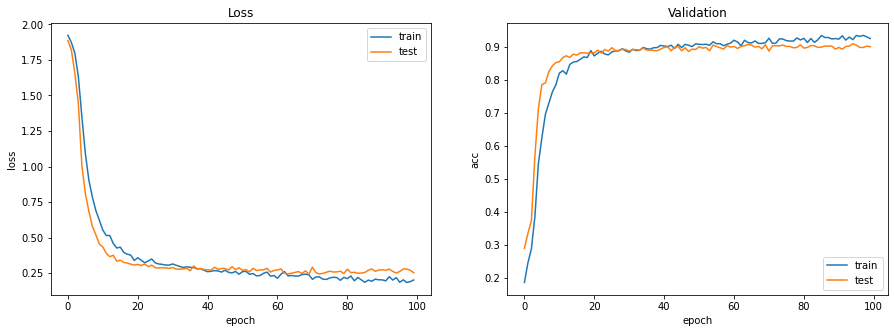

In [30]:
plot_loss_acc(history)
# Evaluamos contra test
score = model.evaluate(X_test, y_test, batch_size=16)
print("Loss: {} \nAccuracy: {}%".format(score[0], score[1]*100))

#### **2.2 EVALUACION**

In [31]:
X_caff_train, X_caff_test, y_caff_train, y_caff_test = processData(array_images_caffe, labels_caffe, 0.2)

In [32]:
print("Entrenamiento: Datos con dimension {}, y clases con {}".format(X_caff_train.shape, y_caff_train.shape))
print("Test: Datos con dimension {}, y clases con {}".format(X_caff_test.shape, y_caff_test.shape))

Entrenamiento: Datos con dimension (201, 40, 30, 3), y clases con (201, 7)
Test: Datos con dimension (51, 40, 30, 3), y clases con (51, 7)


In [33]:
from sklearn.metrics import classification_report

predicted_y = model.predict(X_caff_train)
predicted_y = np.argmax(np.round(predicted_y),axis=1)

categorical_labels = np.argmax(y_caff_train, axis=1)


# Mapeo el nombre de las clases
predicted_y = list(map(EMOTION_MAP.get, predicted_y))
categorical_labels = list(map(EMOTION_MAP.get, categorical_labels))

In [34]:
print(classification_report(categorical_labels, predicted_y))

              precision    recall  f1-score   support

       angry       0.22      0.41      0.29        32
     disgust       0.20      0.30      0.24        30
        fear       0.00      0.00      0.00        29
       happy       0.09      0.08      0.09        25
     neutral       0.00      0.00      0.00        26
         sad       0.16      0.29      0.20        31
    surprise       0.00      0.00      0.00        28

    accuracy                           0.16       201
   macro avg       0.10      0.15      0.12       201
weighted avg       0.10      0.16      0.12       201

